# Cov19: Long-final evaluation

In [8]:
import os
import ast
import sys
import shutil
import joblib
import functools
import statistics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pformat, pprint
from helpers import _build_summary_data, plot_missing_values_per_group, ModelEvaluation
from misc.df_plotter.mv_plotter import MissingValuePlotter
from misc.df_plotter.box_plotter import BoxPlotter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import estimator_html_repr
from IPython.core.display import display, HTML
from IPython.display import Markdown as md
from IPython.display import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


In [9]:
# REMARK: change parameters of this cell and the script/notebook will run for either longitudinal
# or base evaluation, but markdown text will mostly not be influenced. So markdown cells have
# to be adjusted by hand in every script!

study_type = 'long' # 'base', 'long'
target = 'final_result'  # target feature as string
target_mapping = {'survived': 1, 'died': 0}
working_file = "working_file_long_2021-03-22"  # name of working file (without ending) as string
working_dir = "/home/schmidmarco/Documents/CODE/PROJECTS/cov19_pub/scripts/sax-analysis_2/data/simulation_knn_imputation_new_seeds_2"
chosen_model = None # if None best model (mean test accuracy) is taken
re_calculate = False  # time consuming calculations will not be done again if re_calculate = False and file exists in folder
no_features = 15 # number of features for SFS (Feature Importance)
test_size = 0.25  # chosen size of analyzed test set

This notebook shows the methodical way of analyzing the <b>longitudinal data</b> of <b>COV19</b> (died vs. survived)

1. run <b>'train_test_split_analysis.py'</b> with repeated randomized train-test-splits with different split-sizes -> <b>evaluate the optimal fraction to split into train- and test data </b>.

2. selecting 'optimal' train-test-split-size-fraction and <b>getting best model from all supported model types </b> (LogisticRegression, KNeighborsClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier,
GradientBoostingClassifier, SVC). <b>Best model = reaching best mean test-accuracy-score (on unseen data)</b>

3. With this model and its best hyperparameters <b>retrain all data</b> and analyze results with its <b>FeatureImportance</b>

## 1. train_test_split_analysis

In this section the behaviour between train-data-size and test-data-size is analyzed. Goal ist to get an optimal fraction the reach stable and valid results. An optimal fraction is reached if variance in results on train- and test-data is relativly low. Normally many train-data and few test-data leeds to a low variance in train but a high variance in test-results and visa verse. Somewhere between should be an optimum. This fraction is taken for further analysis!

In [10]:
os.chdir(working_dir)

if study_type == 'long':
    data = pd.read_pickle(f"{working_file}.pkl")
else:
    data = pd.read_pickle(f"{working_file}_adjusted.pkl")

In [11]:
fig = MissingValuePlotter(df=data).get_plot()
fig.write_html(f"MissingValuePlotter.html")
fig.show()

In [12]:
data_summary = _build_summary_data(data, target)
fig = plot_missing_values_per_group(data_summary, target)
fig.write_html(f"mv_per_group_before_transformation.html")
fig.show()

From train-test-split-analysis the next 2 plots have been generated:
- data-file have been analyzed with 15 different randomized splits into train- and testdata (random_states: 1211,2341,4351,5641,1521,6541,8961,9851,7471,8681,9011,4321,9801,1921,8561) and different test-sizes (<b>test_sizes: 0.1, 0.15, 0.2, 0.25, 0.3, 0.35</b>)
- the results of this simulation has been plotted per algorithm (<b>LogisticRegression, KNeighborsClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, SVC</b>)

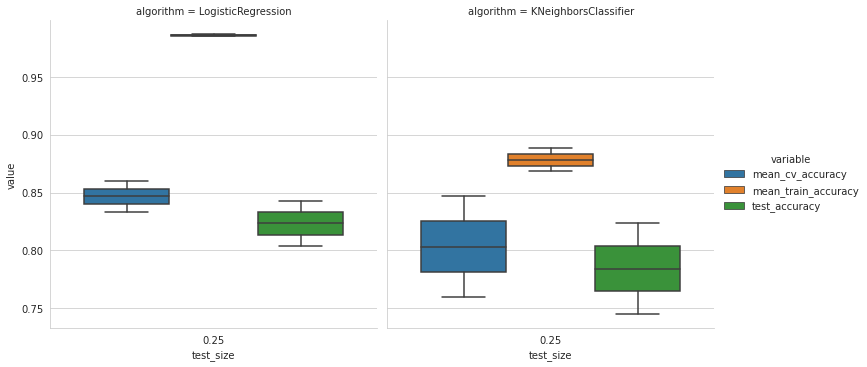

In [13]:
try:
    sim_data = pd.read_csv(f"train_test_split_simulation.csv", index_col=0)
except FileNotFoundError:
    raise Exception(f"File not found!")

data_mod = sim_data.melt(id_vars=['algorithm', 'test_size', 'random_state'],
                     value_vars=['mean_cv_accuracy', 'mean_train_accuracy', 'test_accuracy'])
# build plot
sns.set_style("whitegrid")
sns.catplot(data=data_mod, x='test_size', y='value', col='algorithm', hue='variable', kind='box', col_wrap=2)
plt.savefig(f"train_test_analysis.png")

These plots show the estimated behaviour. With low test-sizes (0.1) the variance in test_accuracy is high. This variance is getting lower if the test_size is increased. From visual sight an optimum could be around a <b>test-size of 0.25</b>. At this point variance of train- and test-accuracy seems to be relatively low.

## 2. getting best model from all suported model types

In a second step the best model of all supported models and hyperparameters is selected. The best model is this one reaching the best mean test-accuracy-score (accuracy score on unseen data).
After catching the <b>optimal train-test-split-size of 0.25</b> only these results will be considered on next steps of this analysis!

Output of former analysis have been two .csv file with all best models (hyperparameters) per algorithm and train-test-split/random_state.

In [14]:
pd.DataFrame(sim_data)

algorithm  simulation  \
0    LogisticRegression           0   
1  KNeighborsClassifier           0   
2    LogisticRegression           1   
3  KNeighborsClassifier           1   

                                         best_params  mean_cv_accuracy  \
0  {'estimator__C': 1, 'estimator__penalty': 'l2'...          0.860000   
1  {'estimator__n_neighbors': 3, 'estimator__weig...          0.846667   
2  {'estimator__C': 1, 'estimator__penalty': 'l2'...          0.833333   
3  {'estimator__n_neighbors': 3, 'estimator__weig...          0.760000   

     cv_std  mean_train_accuracy  train_std  test_accuracy  test_size  \
0  0.038873             0.986667   0.004082       0.803922       0.25   
1  0.040000             0.868333   0.020683       0.745098       0.25   
2  0.036515             0.985000   0.008165       0.843137       0.25   
3  0.092856             0.888333   0.037491       0.823529       0.25   

   random_state  
0          1211  
1          1211  
2          2341  
3          2341

From this tables only <b>test_size=0.25</b> will be taken for further analysis:
The best model overall is the model with the best mean-test-accuracy (on test-size=0.25). It's best hyperparameters are detected in a majority-vote

In [15]:
size_test_data = 0.25

def build_best_param_from_str(params):
    best_param = {}
    param_str = params.index[0]
    param_str = param_str[1:-1]
    param_str_list = str.split(param_str, ',')
    for item in param_str_list:
        item_list = str.split(item, ':')
        for ch in ['"', '\\', "'", " "]:
            item_list[0] = item_list[0].replace(ch, '')
        best_param.update({item_list[0]: eval(item_list[1])})
    return best_param

for i, sd in enumerate([sim_data]):
    data_red = sd[sd['test_size'] == size_test_data]  # optimum between variance in train- and test-score (watch plot)
    best_algorithms = data_red.groupby("algorithm").mean().sort_values(by=['test_accuracy', 'mean_cv_accuracy'], ascending=False)

    if chosen_model is None:
        best_algorithm = best_algorithms.index[0]
        idx = 0
    else:
        best_algorithm = chosen_model
        idx = best_algorithms.index.get_loc(chosen_model)

    best_params = data_red[data_red['algorithm'] == best_algorithm].groupby('best_params').count().sort_values(by="algorithm", ascending=False)
    # best_param = ast.literal_eval(best_params.index[idx])
    best_param = build_best_param_from_str(best_params)

    # performances of best algorithm
    stats = data_red.loc[:, ['mean_cv_accuracy', 'mean_train_accuracy', 'test_accuracy']][
        data_red['algorithm'] == best_algorithm].agg(['mean', 'std'])

    results = {best_algorithm: best_param, 'statistics': stats}
    joblib.dump(results, f"best_model.joblib")
    print(f"{best_algorithm}\n")
    print(f"{best_param}\n")
    print(f"{stats}")

LogisticRegression

{'estimator__C': 1, 'estimator__penalty': 'l2', 'prep__cat_pipeline__imputer_cat__n_neighbors': 1, 'prep__num_pipeline__imputer_num__n_neighbors': 1}

      mean_cv_accuracy  mean_train_accuracy  test_accuracy
mean          0.846667             0.985833       0.823529
std           0.018856             0.001179       0.027730


## 3. Model evaluation and Feature Importance

In former chapters no word about the model pipelines and it's tuning parameters have been lost. These will be shown in this section. Will will analyze data and it's predictions with best evaluated model in section 2.

### EDA

In [16]:
if study_type == 'long':
    data = pd.read_pickle(f"{working_file}.pkl")
else:
    data = pd.read_pickle(f"{working_file}_adjusted.pkl")
data.head(5)

final_result sex   age  albumin_1  albumin_2  albumin_3  albumin_4  crp_1  \
0         died   F  88.0        NaN        NaN        NaN        NaN   0.14   
1     survived   M  71.0        NaN        NaN        NaN        NaN   0.90   
2         died   F  75.0        3.2        NaN        NaN        NaN  10.35   
3         died   M  80.0        NaN        NaN        NaN        NaN   8.55   
4     survived   F  86.0        NaN        NaN        NaN        NaN  11.75   

   crp_2  crp_3  ...  basoQlymphocytes_2  basoQlymphocytes_3  \
0   0.24   1.20  ...            0.022556            0.063291   
1   3.80   8.50  ...            0.022556            0.025424   
2   9.81  13.56  ...            0.017857                 NaN   
3   8.87  14.60  ...            0.014388            0.014493   
4   5.91   3.28  ...            0.013793            0.033898   

   basoQlymphocytes_4  basoQlymphocytes_5  basoQlymphocytes_6  \
0            0.114286            0.047619            0.071429   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3            0.009259            0.025000            0.018519   
4            0.018987            0.009524            0.019324   

   basoQlymphocytes_7  basoQlymphocytes_8  basoQlymphocytes_9  \
0            0.020000                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4            0.015748                 NaN                 NaN   

   basoQlymphocytes_10  basoQlymphocytes_11  
0                  NaN                  NaN  
1                  NaN                  NaN  
2                  NaN                  NaN  
3                  NaN                  NaN  
4                  NaN                  NaN  

[5 rows x 331 columns]

In [17]:
data.describe().T

count       mean        std        min        25%  \
age                  201.0  67.691542  17.501554  22.000000  57.000000   
albumin_1             28.0   3.025000   0.615615   1.800000   2.700000   
albumin_2             11.0   2.745455   0.733980   1.900000   2.350000   
albumin_3              3.0   3.000000   0.984886   1.900000   2.600000   
albumin_4              1.0   2.800000        NaN   2.800000   2.800000   
...                    ...        ...        ...        ...        ...   
basoQlymphocytes_7    16.0   0.057371   0.085875   0.011050   0.016943   
basoQlymphocytes_8     6.0   0.029425   0.019775   0.007752   0.016884   
basoQlymphocytes_9     1.0   0.021858        NaN   0.021858   0.021858   
basoQlymphocytes_10    1.0   0.040698        NaN   0.040698   0.040698   
basoQlymphocytes_11    0.0        NaN        NaN        NaN        NaN   

                           50%        75%        max  
age                  70.000000  80.000000  96.000000  
albumin_1             3.150000   3.225000   4.500000  
albumin_2             2.500000   3.050000   4.300000  
albumin_3             3.300000   3.550000   3.800000  
albumin_4             2.800000   2.800000   2.800000  
...                        ...        ...        ...  
basoQlymphocytes_7    0.032537   0.053105   0.361111  
basoQlymphocytes_8    0.026724   0.035371   0.063492  
basoQlymphocytes_9    0.021858   0.021858   0.021858  
basoQlymphocytes_10   0.040698   0.040698   0.040698  
basoQlymphocytes_11        NaN        NaN        NaN  

[300 rows x 8 columns]

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 200
Columns: 331 entries, final_result to basoQlymphocytes_11
dtypes: category(31), float64(300)
memory usage: 482.5 KB


In [19]:
if study_type == 'base':
    if not os.path.isfile('pairplot.png'):
        plt.figure(figsize=(15,8))
        fig = sns.pairplot(data=data, hue='group', plot_kws={'alpha':0.2})
        fig.savefig('pairplot.png')
    else:
        display(Image(filename='pairplot.png'))

In [20]:
mv = data.isna().sum().sum()
frac = round((mv / (data.shape[0]*data.shape[1])) * 100, 3)
md("The data contains <b>{}</b> missing values in overall, that is a fraction of <b>{}</b>%.".format(mv, frac))

The data contains <b>44160</b> missing values in overall, that is a fraction of <b>66.375</b>%.

The missing value-plot is already shown in part 1 as well as the missing data per subgropup.

In [21]:
if study_type == 'base':
    bp = BoxPlotter(df=data, features=None, split=target)
    bp.update_layout(n_cols=3, n_rows=3, style_grid={'vertical_spacing': 0.1, 'horizontal_spacing': 0.1},
                     colors={'positive': 'green', 'negative': 'red'}, style_figure={'boxpoints': 'all'})
    figs = bp.get_plot()
    for idx, item in enumerate(figs):
        item.update_layout(title_text=f"Boxplot {idx}", width=1600, height=800)
        item.show()

    bp.store(path=f'{os.getcwd()}', name=f"BoxPlotter")

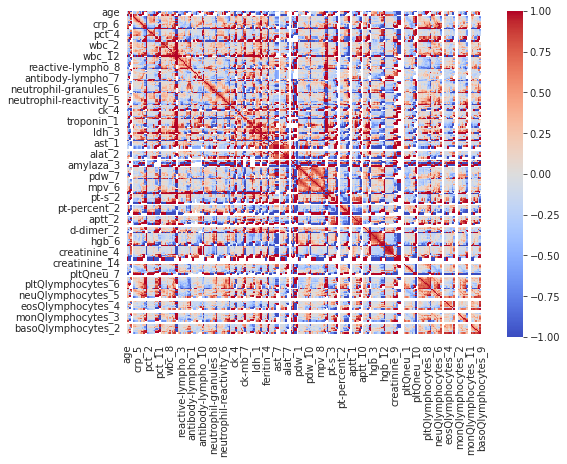

In [22]:
plt.figure(figsize=(8,6))
sns.heatmap(data=data.corr(), cmap='coolwarm')
plt.show()

Next target variable has to be replaced by numeric values to calculate correlation of features to target.

In [23]:
data_mod = data.copy()
data_mod[target] = data_mod[target].map(target_mapping)
data_mod[target] = data_mod[target].astype('float')
data_mod.corr()[target].sort_values()

hgb_12                -1.000000
pt-s_8                -1.000000
aptt_8                -0.999971
amylaza_3             -0.993399
alat_7                -0.990926
                         ...   
monQlymphocytes_10          NaN
monQlymphocytes_11          NaN
basoQlymphocytes_9          NaN
basoQlymphocytes_10         NaN
basoQlymphocytes_11         NaN
Name: final_result, Length: 301, dtype: float64

### Machine Learning

The pipeline for the ML-workflow looks as following:

In [24]:
pipe = joblib.load(f'pipe.joblib')

In [25]:
params = joblib.load(f'params.joblib')
print(pformat(params))

([{'prep__cat_pipeline__imputer_cat__n_neighbors': [1, 3],
   'prep__num_pipeline__imputer_num__n_neighbors': [1, 3]}],
 [{'estimator': [LogisticRegression()],
   'estimator__C': [1],
   'estimator__penalty': ['l2']},
  {'estimator': [KNeighborsClassifier()],
   'estimator__n_neighbors': [3],
   'estimator__weights': ['uniform', 'distance']}])


Best hyperparameters as well as the performance statistics have been evaluated in section above: These are:

In [26]:
results = joblib.load(f"best_model.joblib")
keys = list(results.keys())
best_algorithm_name = keys[0]
print(f"Best algorithm: {best_algorithm_name}\n")
print(f"Best parameters: {results.get(keys[0])}\n")
print(f"statistics: {results.get(keys[1])}")

Best algorithm: LogisticRegression

Best parameters: {'estimator__C': 1, 'estimator__penalty': 'l2', 'prep__cat_pipeline__imputer_cat__n_neighbors': 1, 'prep__num_pipeline__imputer_num__n_neighbors': 1}

statistics:       mean_cv_accuracy  mean_train_accuracy  test_accuracy
mean          0.846667             0.985833       0.823529
std           0.018856             0.001179       0.027730


The model will be build from pipeline by replacing the dummy estimator by the best estimator and update the hyperparameters in the pipe. After this the pipe can be fitted on overall data!

In [27]:
X = data.drop([target], axis=1)
y = data[target]
y = y.map(target_mapping)  # for precision_scorer labels have to be binary with 0,1

In [28]:
updated_params = results.get(keys[0])
updated_params = {key:[value] for key,value in updated_params.items()}  # values have to be defined as list
updated_pipe = pipe
updated_pipe.steps.pop(-1)
updated_pipe.steps.append(('estimator', eval(f"{keys[0]}()")))  # adding () behind best model name and evaluate -> function

In [29]:
kfold = KFold(n_splits=5, shuffle=True)
model = GridSearchCV(estimator=updated_pipe ,param_grid=updated_params, cv=kfold ,n_jobs=-1,
                     return_train_score=True, scoring='accuracy', refit=True)
model.fit(X, y)
display(HTML(estimator_html_repr(model.best_estimator_)))

In [30]:
model.cv_results_

{'mean_fit_time': array([4.47365203]),
 'std_fit_time': array([0.54444842]),
 'mean_score_time': array([1.01019673]),
 'std_score_time': array([0.25198457]),
 'param_estimator__C': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_estimator__penalty': masked_array(data=['l2'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_prep__cat_pipeline__imputer_cat__n_neighbors': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_prep__num_pipeline__imputer_num__n_neighbors': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__C': 1,
   'estimator__penalty': 'l2',
   'prep__cat_pipeline__imputer_cat__n_neighbors': 1,
   'prep__num_pipeline__imputer_num__n_neighbors': 1}],
 'split0_test_score': array([0.85365854]),
 'split1_test_score': array([0.875]),
 'split2_te

In [31]:
md('Best model cross-validated score is <b>{}</b>'.format(model.best_score_))

Best model cross-validated score is <b>0.8557317073170732</b>

### Predictions

The performance in prediction (example) can be slightly optimistic because the model was refit on all data (no train-, test). But in statistics above the 'true' (estimated) statistic values are shown.

In [32]:
y_pred = model.predict(X)

In [33]:
model.predict(X)[0:10]

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1])

In [34]:
try:
    model.predict_proba(X)[0:10]
except:
    pass

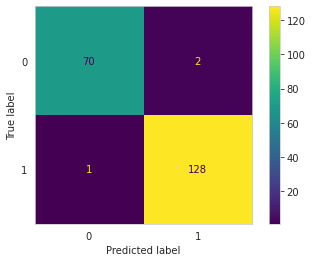

In [35]:
plt.Figure(figsize=(10,6))
plot_confusion_matrix(estimator=model, X=X, y_true=y)
plt.grid()
plt.savefig(f'confusion_matrix.png')

In [36]:
correct_classified = sum(model.predict(X) == y)
all_classified = len(y)
missclassified = all_classified - correct_classified
md('There are <b>{}</b> missclassifications on a total of <b>{}</b> observations'.format(missclassified, all_classified))

There are <b>3</b> missclassifications on a total of <b>201</b> observations

In [37]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.98      0.99      0.99       129

    accuracy                           0.99       201
   macro avg       0.99      0.98      0.98       201
weighted avg       0.99      0.99      0.99       201



Confusion matrix as well as the classification report showing a well distributed picture. Precision, recall and f1-score are very close, so the model seems to work quit accurate!
<br> 
<br>
<b>ATTENTION:</b> 
<br>The results of the classification report and confussion matrix are based on all data and this fitted data! The 'real' predictions on seen data are lower (see accuracy on test-data of about 82%). The model overfitts...

### Feature Importance

This section tries to highlight the most important features in the dataset. Two approaches are chosen:
1. <b>regression coefficients</b> (only possible in regression models as LogisticRegression)
2. Feature importance with <b>SequentialFeatureSelection</b>

In [38]:
position_estimator = [idx for idx, i in enumerate(list(model.best_estimator_.named_steps)) if i == 'estimator'][0]
best_estimator = model.best_estimator_.steps.pop(position_estimator)[1]
preprocessed_x = model.best_estimator_.fit_transform(X)

In [39]:
if isinstance(preprocessed_x, pd.DataFrame):
    cols = preprocessed_x.columns
else:
    cols = X.columns

ldh_aa                      1.274404
monQlymphocytes_bb          1.178115
crp_aa                      0.963445
wbc_aa                      0.880431
neuQlymphocytes_ba          0.824529
                              ...   
neutrophil-reactivity_bb   -1.012120
crp_bb                     -1.169997
wbc_bb                     -1.177287
age                        -1.488603
hypertension               -1.812148
Length: 121, dtype: float64


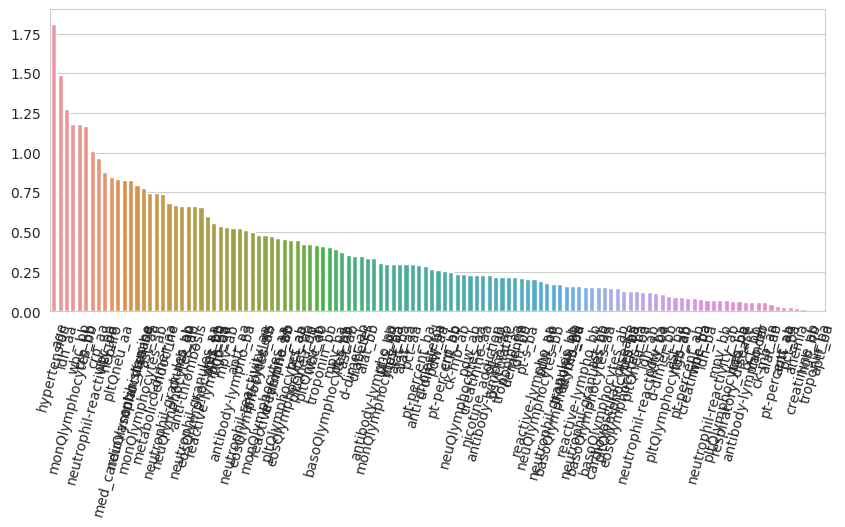

In [40]:
if best_algorithm_name == 'LogisticRegression':
    coefs = pd.Series(index=cols, data=best_estimator.coef_[0])
    coefs = coefs.sort_values(ascending=False)
    coefs_abs = abs(coefs).sort_values(ascending=False)
    print(coefs)

    # build plot
    plt.figure(figsize=(10,4), dpi=100)
    ax = sns.barplot(x=coefs_abs.index, y=coefs_abs.values)
    for item in ax.get_xticklabels():
        item.set_rotation(75)
    fig = ax.get_figure()
    fig.savefig(f'feature_importance.png')

    md("The most important features seems to be <b>{}</b>".format(coefs[0:7].index.to_list()))

A second approach for the feature importance is the sequential feature selection (SFS).

SFS does not work with a pipeline object, therefore the estimator will be removed, data will be preprocessed with pipe without estimator and this estimator is given to SFS.

In [41]:
if re_calculate is False and os.path.isfile('feature_importance.joblib'):
    feature_importance = joblib.load('feature_importance.joblib')
    sfs = joblib.load('sfs.joblib')
else:
    sfs = SFS(best_estimator,
               k_features=no_features,
               forward=True,
               scoring='accuracy',
               cv=5,
               n_jobs=-1)
    sfs = sfs.fit(preprocessed_x, y, custom_feature_names=cols.to_list())
    feature_importance = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
    joblib.dump(feature_importance, 'feature_importance.joblib')
    joblib.dump(sfs, 'sfs.joblib')

feature_importance

feature_idx  \
1                                               (72,)   
2                                            (72, 82)   
3                                        (54, 72, 82)   
4                                    (54, 60, 72, 82)   
5                               (54, 60, 72, 82, 106)   
6                           (54, 60, 69, 72, 82, 106)   
7                        (9, 54, 60, 69, 72, 82, 106)   
8                   (9, 54, 60, 69, 72, 82, 106, 118)   
9               (9, 13, 54, 60, 69, 72, 82, 106, 118)   
10          (9, 11, 13, 54, 60, 69, 72, 82, 106, 118)   
11      (9, 11, 13, 54, 60, 67, 69, 72, 82, 106, 118)   
12  (9, 11, 12, 13, 54, 60, 67, 69, 72, 82, 106, 118)   
13  (9, 11, 12, 13, 18, 54, 60, 67, 69, 72, 82, 10...   
14  (9, 11, 12, 13, 16, 18, 54, 60, 67, 69, 72, 82...   
15  (9, 11, 12, 13, 16, 18, 22, 54, 60, 67, 69, 72...   

                                         cv_scores avg_score  \
1   [0.6829268292682927, 0.775, 0.725, 0.8, 0.825]  0.761585   
2      [0.7317073170731707, 0.8, 0.75, 0.8, 0.825]  0.781341   
3    [0.7317073170731707, 0.8, 0.75, 0.825, 0.825]  0.786341   
4    [0.7560975609756098, 0.825, 0.75, 0.85, 0.85]   0.80622   
5   [0.7560975609756098, 0.825, 0.8, 0.875, 0.875]   0.82622   
6    [0.7804878048780488, 0.875, 0.85, 0.85, 0.95]  0.861098   
7    [0.7804878048780488, 0.875, 0.875, 0.9, 0.95]  0.876098   
8       [0.8780487804878049, 0.85, 0.9, 0.9, 0.95]   0.89561   
9      [0.8780487804878049, 0.875, 0.9, 0.9, 0.95]   0.90061   
10     [0.8780487804878049, 0.875, 0.9, 0.9, 0.95]   0.90061   
11   [0.8780487804878049, 0.875, 0.9, 0.925, 0.95]   0.90561   
12   [0.8780487804878049, 0.875, 0.9, 0.925, 0.95]   0.90561   
13   [0.8780487804878049, 0.875, 0.9, 0.925, 0.95]   0.90561   
14   [0.8780487804878049, 0.875, 0.9, 0.925, 0.95]   0.90561   
15   [0.8780487804878049, 0.875, 0.9, 0.925, 0.95]   0.90561   

                                        feature_names  ci_bound   std_dev  \
1                                           (crp_bb,)  0.066046  0.051386   
2                                    (crp_bb, pct_ab)  0.044702   0.03478   
3                        (pltQneu_ab, crp_bb, pct_ab)  0.049716  0.038681   
4         (pltQneu_ab, creatinine_bb, crp_bb, pct_ab)  0.057073  0.044405   
5   (pltQneu_ab, creatinine_bb, crp_bb, pct_ab, hy...   0.05852   0.04553   
6   (pltQneu_ab, creatinine_bb, crp_aa, crp_bb, pc...  0.070025  0.054481   
7   (ast_aa, pltQneu_ab, creatinine_bb, crp_aa, cr...  0.070811  0.055094   
8   (ast_aa, pltQneu_ab, creatinine_bb, crp_aa, cr...  0.042182  0.032819   
9   (ast_aa, pdw_aa, pltQneu_ab, creatinine_bb, cr...  0.034512  0.026851   
10  (ast_aa, ast_ba, pdw_aa, pltQneu_ab, creatinin...  0.034512  0.026851   
11  (ast_aa, ast_ba, pdw_aa, pltQneu_ab, creatinin...  0.036691  0.028546   
12  (ast_aa, ast_ba, ast_bb, pdw_aa, pltQneu_ab, c...  0.036691  0.028546   
13  (ast_aa, ast_ba, ast_bb, pdw_aa, d-dimer_ab, p...  0.036691  0.028546   
14  (ast_aa, ast_ba, ast_bb, pdw_aa, pdw_bb, d-dim...  0.036691  0.028546   
15  (ast_aa, ast_ba, ast_bb, pdw_aa, pdw_bb, d-dim...  0.036691  0.028546   

     std_err  
1   0.025693  
2    0.01739  
3   0.019341  
4   0.022202  
5   0.022765  
6   0.027241  
7   0.027547  
8    0.01641  
9   0.013426  
10  0.013426  
11  0.014273  
12  0.014273  
13  0.014273  
14  0.014273  
15  0.014273

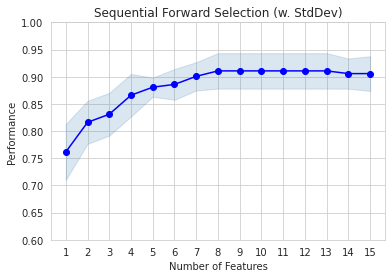

In [36]:
plt.Figure(figsize=(10,6))
plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.ylim([0.6,1.0])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.savefig('sfs.png')

# Evaluate all  (best) models (Feature Importance)

In [42]:
def transform_feature_importance_to_list(feature_importance):
        feature_list = []
        for idx, item in enumerate(feature_importance['feature_names']):
            if idx == 0:
                feature_list.append(item[0])
            else:
                diff = [i for i in item if i not in feature_list]
                feature_list.append(diff[0])
        return feature_list
feature_importance_list = transform_feature_importance_to_list(feature_importance)
md("The most important features seems to be <br><br> <b>{}</b> <br><br> -> ordered by importance from important to less important!".format(feature_importance_list))

The most important features seems to be <br><br> <b>['crp_bb', 'pct_ab', 'pltQneu_ab', 'creatinine_bb', 'hypertension', 'crp_aa', 'ast_aa', 'nephro', 'pdw_aa', 'ast_ba', 'alat_ba', 'ast_bb', 'd-dimer_ab', 'pdw_bb', 'neutrophil-reactivity_ab']</b> <br><br> -> ordered by importance from important to less important!

In [43]:
no_features = 10

In [44]:
if study_type == 'long':
    wf = f"{working_file}"
else:
    wf = f"{working_file}_adjusted"

evaluation = ModelEvaluation(working_file = f"{wf}.pkl",
                             target=target,
                             simulation_file='train_test_split_simulation.csv',
                             pipe='pipe.joblib')

In [45]:
if re_calculate is False and os.path.isfile('overview_models.joblib'):
    overview_models = joblib.load('overview_models.joblib')
else:
    overview_models = evaluation.analyze_models(test_size=test_size, no_features=no_features)
    joblib.dump(overview_models, 'overview_models.joblib')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [46]:
pprint(overview_models)

NameError: name 'overview_models' is not defined

# Final Feature Importance


To calculate the final feature importance th 10 best features of every (best) algorithm is taken. These features got rank 1 to 10 (and 11 for all not used features). The median rank of all 7 algorithms givs the final feature importance: 

In [41]:
overview_models = joblib.load('overview_models.joblib')

In [42]:
# giving rank points
rank_list = []
for model in overview_models:
    rank = {}
    for idx, item in enumerate(model['4_features']):
        rank.update({item: [idx+1]})
    rank_list.append(rank)
pprint(rank_list)

[{'ast_aa': [7],
  'creatinine_bb': [4],
  'crp_aa': [6],
  'crp_bb': [1],
  'hypertension': [5],
  'nephro': [8],
  'pct_ab': [2],
  'pdw_aa': [9],
  'pltQlymphocytes_ab': [10],
  'pltQneu_ab': [3]},
 {'age': [2],
  'alat_ba': [8],
  'alat_bb': [10],
  'anti-platelets': [3],
  'ast_ab': [7],
  'cancer': [4],
  'mpv_ba': [5],
  'pdw_ba': [9],
  'pltQlymphocytes_ab': [6],
  'wbc_aa': [1]},
 {'age': [2],
  'antibody-lympho_ab': [10],
  'basoQlymphocytes_bb': [6],
  'crp_aa': [7],
  'crp_bb': [1],
  'd-dimer_aa': [9],
  'hypertension': [8],
  'pct_aa': [5],
  'troponin_aa': [4],
  'wbc_aa': [3]},
 {'age': [2],
  'crp_bb': [1],
  'd-dimer_aa': [9],
  'hypertension': [6],
  'monQlymphocytes_ab': [7],
  'neuQlymphocytes_bb': [8],
  'pct_aa': [4],
  'pltQlymphocytes_bb': [10],
  'wbc_aa': [3],
  'wbc_bb': [5]},
 {'age': [2],
  'ast_bb': [7],
  'crp_ab': [5],
  'crp_bb': [1],
  'd-dimer_aa': [6],
  'pltQlymphocytes_ba': [9],
  'respiratory_disease': [4],
  'troponin_ab': [8],
  'troponin_ba': 

In [43]:
# combining all dictionaries
def combine_dict(dict1,dict2):
    dict3 = {}
    for key in set().union(dict1, dict2):
        if key in dict1: dict3.setdefault(key, []).extend(dict1[key])
        if key in dict2: dict3.setdefault(key, []).extend(dict2[key])
    return dict3

combined_dict = functools.reduce(lambda a,b : combine_dict(a,b) ,rank_list)
print(combined_dict)

{'pltQlymphocytes_ab': [10, 6, 9], 'd-dimer_aa': [9, 9, 6, 10], 'mpv_bb': [8], 'pltQlymphocytes_aa': [7], 'ast_aa': [7], 'troponin_aa': [4], 'pct_aa': [5, 4], 'pdw_ba': [9], 'alat_bb': [10], 'ast_bb': [7], 'pltQlymphocytes_ba': [9, 10], 'wbc_aa': [1, 3, 3, 3, 4], 'alat_ba': [8], 'mpv_ba': [5], 'aptt_bb': [8], 'troponin_ba': [10], 'troponin_ab': [8], 'basoQlymphocytes_bb': [6], 'pdw_aa': [9], 'pct_ab': [2], 'respiratory_disease': [4], 'hypertension': [5, 8, 6], 'monQlymphocytes_bb': [9], 'pltQneu_ab': [3, 7], 'pct_ba': [6], 'nephro': [8], 'pltQlymphocytes_bb': [10], 'crp_aa': [6, 7], 'creatinine_bb': [4, 3], 'wbc_bb': [5], 'antibody-lympho_ab': [10], 'neuQlymphocytes_bb': [8], 'cancer': [4], 'crp_ab': [5, 4], 'ldh_aa': [5], 'ast_ab': [7], 'monQlymphocytes_ab': [7, 5], 'age': [2, 2, 2, 2, 2, 2], 'creatinine_ab': [6], 'antibody-lympho_ba': [3], 'anti-platelets': [3], 'crp_bb': [1, 1, 1, 1, 1, 1]}


In [44]:
# extend dictionaries with 11 until length of number of algorithms is reached (7)
extended_dict = {}
for k,v in combined_dict.items():
    l = v + [11]*(7-len(v))
    extended_dict.update({k: l})
print(extended_dict)

{'pltQlymphocytes_ab': [10, 6, 9, 11, 11, 11, 11], 'd-dimer_aa': [9, 9, 6, 10, 11, 11, 11], 'mpv_bb': [8, 11, 11, 11, 11, 11, 11], 'pltQlymphocytes_aa': [7, 11, 11, 11, 11, 11, 11], 'ast_aa': [7, 11, 11, 11, 11, 11, 11], 'troponin_aa': [4, 11, 11, 11, 11, 11, 11], 'pct_aa': [5, 4, 11, 11, 11, 11, 11], 'pdw_ba': [9, 11, 11, 11, 11, 11, 11], 'alat_bb': [10, 11, 11, 11, 11, 11, 11], 'ast_bb': [7, 11, 11, 11, 11, 11, 11], 'pltQlymphocytes_ba': [9, 10, 11, 11, 11, 11, 11], 'wbc_aa': [1, 3, 3, 3, 4, 11, 11], 'alat_ba': [8, 11, 11, 11, 11, 11, 11], 'mpv_ba': [5, 11, 11, 11, 11, 11, 11], 'aptt_bb': [8, 11, 11, 11, 11, 11, 11], 'troponin_ba': [10, 11, 11, 11, 11, 11, 11], 'troponin_ab': [8, 11, 11, 11, 11, 11, 11], 'basoQlymphocytes_bb': [6, 11, 11, 11, 11, 11, 11], 'pdw_aa': [9, 11, 11, 11, 11, 11, 11], 'pct_ab': [2, 11, 11, 11, 11, 11, 11], 'respiratory_disease': [4, 11, 11, 11, 11, 11, 11], 'hypertension': [5, 8, 6, 11, 11, 11, 11], 'monQlymphocytes_bb': [9, 11, 11, 11, 11, 11, 11], 'pltQneu

In [45]:
# calculate median of each item
median = {}
for k,v in extended_dict.items():
    median.update({k: statistics.median(v)})
print(median)

{'pltQlymphocytes_ab': 11, 'd-dimer_aa': 10, 'mpv_bb': 11, 'pltQlymphocytes_aa': 11, 'ast_aa': 11, 'troponin_aa': 11, 'pct_aa': 11, 'pdw_ba': 11, 'alat_bb': 11, 'ast_bb': 11, 'pltQlymphocytes_ba': 11, 'wbc_aa': 3, 'alat_ba': 11, 'mpv_ba': 11, 'aptt_bb': 11, 'troponin_ba': 11, 'troponin_ab': 11, 'basoQlymphocytes_bb': 11, 'pdw_aa': 11, 'pct_ab': 11, 'respiratory_disease': 11, 'hypertension': 11, 'monQlymphocytes_bb': 11, 'pltQneu_ab': 11, 'pct_ba': 11, 'nephro': 11, 'pltQlymphocytes_bb': 11, 'crp_aa': 11, 'creatinine_bb': 11, 'wbc_bb': 11, 'antibody-lympho_ab': 11, 'neuQlymphocytes_bb': 11, 'cancer': 11, 'crp_ab': 11, 'ldh_aa': 11, 'ast_ab': 11, 'monQlymphocytes_ab': 11, 'age': 2, 'creatinine_ab': 11, 'antibody-lympho_ba': 11, 'anti-platelets': 11, 'crp_bb': 1}


In [46]:
# sorting items with values
{k: v for k, v in sorted(median.items(), key=lambda item: item[1])}

{'crp_bb': 1,
 'age': 2,
 'wbc_aa': 3,
 'd-dimer_aa': 10,
 'pltQlymphocytes_ab': 11,
 'mpv_bb': 11,
 'pltQlymphocytes_aa': 11,
 'ast_aa': 11,
 'troponin_aa': 11,
 'pct_aa': 11,
 'pdw_ba': 11,
 'alat_bb': 11,
 'ast_bb': 11,
 'pltQlymphocytes_ba': 11,
 'alat_ba': 11,
 'mpv_ba': 11,
 'aptt_bb': 11,
 'troponin_ba': 11,
 'troponin_ab': 11,
 'basoQlymphocytes_bb': 11,
 'pdw_aa': 11,
 'pct_ab': 11,
 'respiratory_disease': 11,
 'hypertension': 11,
 'monQlymphocytes_bb': 11,
 'pltQneu_ab': 11,
 'pct_ba': 11,
 'nephro': 11,
 'pltQlymphocytes_bb': 11,
 'crp_aa': 11,
 'creatinine_bb': 11,
 'wbc_bb': 11,
 'antibody-lympho_ab': 11,
 'neuQlymphocytes_bb': 11,
 'cancer': 11,
 'crp_ab': 11,
 'ldh_aa': 11,
 'ast_ab': 11,
 'monQlymphocytes_ab': 11,
 'creatinine_ab': 11,
 'antibody-lympho_ba': 11,
 'anti-platelets': 11}

In [47]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [48]:
# store this notebook as html in specific folder
os.system(f'jupyter nbconvert --to html final_evaluation.ipynb')

256